# **Exercise:**

Approximate function:
`f(x) = sin(2x) + sin(x)`

Steps:


1.   Disable CUDA
2.   Import Keras



In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # '-1' is CPU, '0' - 1st GPU, '1' - 2nd GPU...

In [5]:
import tensorflow.keras as keras

Let's create test and validation data for our problem

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

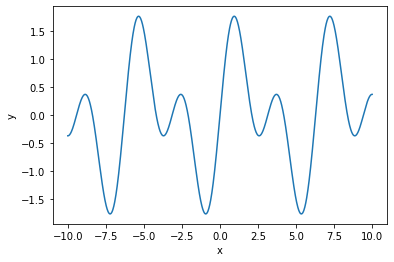

In [7]:
x = np.linspace(-10, 10, 1000)
y = np.sin(2*x) + np.sin(x)
x = list(x)
plt.plot(x,y)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

The problem is a regression problem where we try to predict a quantity.

Let's create a first experimental model with 5 layers and 1 input and 1 output.

Let's use the standard ReLU linear activation function in the layers (except output).

In [8]:
def cos_activation(x):
  return keras.backend.cos(x)

def experimental_model():
  # Input layer will accept two float values - let's give this layer name "input"
  model_input = keras.layers.Input(shape=(1,), dtype='float32', name="input")

  # four hidden dense (fully connected) layers
  # where each hidden layer is 10 outputs lower than previous one
  # all will use ReLu activation functions
  x = keras.layers.Dense(40, use_bias=True, activation=cos_activation, name="dense_1")(model_input)
  x = keras.layers.Dense(30, use_bias=True, activation=cos_activation, name="dense_2")(x)
  x = keras.layers.Dense(20, use_bias=True, activation=cos_activation, name="dense_3")(x)
  x = keras.layers.Dense(10, use_bias=True, activation=cos_activation, name="dense_4")(x)

  # Output layer will be the same size as input layer - without any activation function
  model_output = keras.layers.Dense(1, use_bias=True, name="dense_output")(x)

  model = keras.Model(inputs=[model_input], outputs=[model_output])

  return model


Let's summarize the model and plot it using keras plot model utility function

In [9]:
model = experimental_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 40)                80        
                                                                 
 dense_2 (Dense)             (None, 30)                1230      
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_output (Dense)        (None, 1)                 11        
                                                                 
Total params: 2,151
Trainable params: 2,151
Non-trainable par

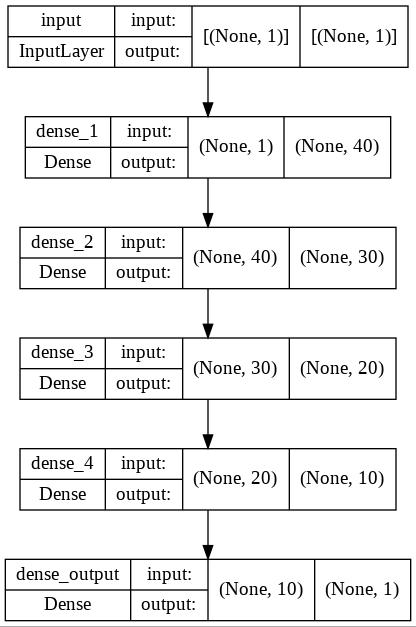

In [10]:
model.summary()
keras.utils.plot_model(model, to_file="experimental_model.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Now we can start defining optimizers, loss functions, creating metrics that we're going to track.

In [11]:
# We will use ADAM optimizer as it is one of the most effective ones
opt = keras.optimizers.Adam()
# For loss function we will use MeanSquareError
loss = keras.losses.MeanSquaredError()
# As an additional metric we will use Mean Absolute Error. Because training can only optimize based on one loss function. But we want to see if our another metric (absolute error) is also getting lower when training
metric_mae = keras.metrics.MeanAbsoluteError()

Let's compile the model

In [12]:
model.compile(optimizer=opt, loss=loss, metrics=[metric_mae], run_eagerly=False,)

Let's define input data/output data.

After that let's shuffle the data - as it's a good practice to let our model achieve better results.

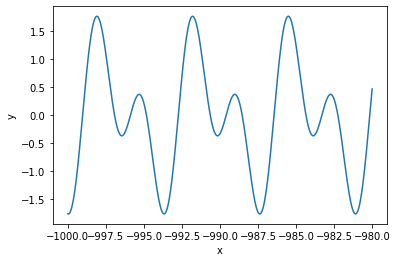

In [13]:
# While doing other (sin) function approximation it was clear that amount of data is the most important thing in order for the model to learn periodicy
# So let's create a bigger array of input data
input_data = np.linspace(-1000, 1000, num=100000)
# Output data will be the input data ran through our function sin(2x) + sin(x)
output_data = np.sin(2*input_data) + np.sin(input_data)

# Creating a shuffling function
def shuffled_copies(a, b): #both arrays should have the same length
    p = np.random.permutation(len(a)) #get shuffled indexes
    return a[p], b[p]

# We use the shuffled data in the training as it improves model fitting.
shuffled_input_data, shuffled_output_data = shuffled_copies(input_data, output_data)

# Let's check and plot our data we're training with
plt.plot(list(input_data[0:1000]), output_data[0:1000])
plt.ylabel('y')
plt.xlabel('x')
plt.show()

Let's define batch size and epochs for training. And then start our training process

In [28]:

os.makedirs("weights", exist_ok=True) #make folder for storing model weights

#let's save promising models during training
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath="weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                                                            save_weights_only=True, #saving weights, as we have custom activation
                                                            monitor='val_loss', #we will watch validation loss
                                                            mode='min', #we want to save minimum validation loss only
                                                            save_best_only=True)

# Using batch size of 128 as there are a million numbers.
# Epochs 100 as I saw a degradation of performance after the last 90th epochs 
batch_size = 128
epochs = 100

#we will store training history in train_history
train_history = model.fit(shuffled_input_data,
                           shuffled_output_data,
                           batch_size=batch_size,
                           epochs=epochs,
                           callbacks=[model_checkpoint_callback],
                           validation_split=0.1);

Epoch 1/100
704/704 [==============================] - 2s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0468 - val_loss: 9.6189e-04 - val_mean_absolute_error: 0.0231
Epoch 2/100
704/704 [==============================] - 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0609 - val_loss: 0.0032 - val_mean_absolute_error: 0.0431
Epoch 3/100
704/704 [==============================] - 2s 2ms/step - loss: 0.0183 - mean_absolute_error: 0.0577 - val_loss: 7.1405e-04 - val_mean_absolute_error: 0.0196
Epoch 4/100
704/704 [==============================] - 2s 2ms/step - loss: 0.0043 - mean_absolute_error: 0.0373 - val_loss: 0.0165 - val_mean_absolute_error: 0.0881
Epoch 5/100
704/704 [==============================] - 2s 2ms/step - loss: 0.0785 - mean_absolute_error: 0.1627 - val_loss: 0.1296 - val_mean_absolute_error: 0.2768
Epoch 6/100
704/704 [==============================] - 2s 2ms/step - loss: 0.0480 - mean_absolute_error: 0.1524 - val_loss: 0.0059 - val_mean_absolute_error: 0.0603
Ep

Testing the result on limited data set (which it was trained on)

In [29]:
predicted_data = model.predict(input_data)

(100000, 1)


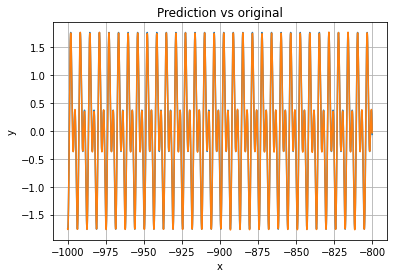

In [30]:
plt.figure()
plt.grid()
plt.title("Prediction vs original")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(input_data[0:10000], output_data[0:10000], input_data[0:10000], predicted_data[0:10000]);
print(predicted_data.shape)

We can see that it looks good. Let's try to predict on data that was not covered yet.

In [31]:
# Creating new data that was not trained on the network
input_data_long = np.linspace(4950, 5000, num=1000)
output_data_long = np.sin(2*input_data_long) + np.sin(input_data_long)

In [32]:
predicted_data_long = model.predict(input_data_long)

Let's visualize the prediction on unseen data

(1000, 1)


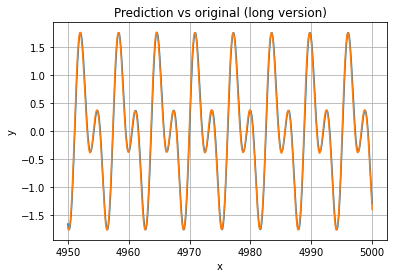

In [33]:
plt.figure()
plt.grid()
plt.title("Prediction vs original (long version)")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(input_data_long, output_data_long, input_data_long, predicted_data_long);
print(predicted_data_long.shape)